In [1]:
from urllib.request import urlretrieve
#import urllib

from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

"""
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


# In[2]:


import pickle
import numpy as np
import matplotlib.pyplot as plt
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


# In[3]:


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))

    plt.imshow(sample_image)



# Explore the dataset
batch_id = 3
sample_id = 9999
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)


# In[7]:


features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
sample_image = features[0]
#plt.imshow(sample_image)
imageTest = features[0:100]
imageTest.shape


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 9999:
Image - Min Value: 3 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


(100, 32, 32, 3)

In [2]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x


# In[9]:


def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded


# In[10]:


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)

        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation],
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')



preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)


# In[12]:


import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))


# ## placeholder variables


In [3]:
import tensorflow as tf
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')


# In[14]:


conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))


# In[ ]:





# In[15]:


epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001


# In[16]:


#logits = conv_net(x, keep_prob)
#model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training


# In[17]:


conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.relu(conv1)
conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# In[18]:


conv1


# In[19]:


conv2 = tf.nn.conv2d(conv1_pool, conv2_filter, strides=[1,1,1,1], padding='SAME')
conv2 = tf.nn.relu(conv2)
conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# In[20]:


conv2_pool


# In[21]:


conv3 = tf.nn.conv2d(conv2_pool, conv3_filter, strides=[1,1,1,1], padding='SAME')
conv3 = tf.nn.relu(conv3)
conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


In [4]:
conv4 = tf.nn.conv2d(conv3_pool, conv4_filter, strides=[1,1,1,1], padding='SAME')
conv4 = tf.nn.relu(conv4)
conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# In[24]:


conv4_pool


# In[25]:


flat = tf.contrib.layers.flatten(conv4_pool)



fc1_filter = tf.Variable(tf.truncated_normal(shape=[2048, 128], mean=0, stddev=0.08))
fc1 = tf.matmul(flat, fc1_filter)
full1 = tf.nn.dropout(fc1, keep_prob)


# In[27]:


# In[28]:


fc2_filter = tf.Variable(tf.truncated_normal(shape=[128, 256], mean = 0, stddev=0.08))
fc2 = tf.matmul(full1, fc2_filter)
full2 = tf.nn.dropout(fc2, keep_prob)




fc3_filter = tf.Variable(tf.truncated_normal(shape=[256, 512], mean = 0, stddev=0.08))
fc3 = tf.matmul(full2, fc3_filter)
full3 = tf.nn.dropout(fc3, keep_prob)



fc4_filter = tf.Variable(tf.truncated_normal(shape=[512, 1024], mean = 0, stddev=0.08))
fc4 = tf.matmul(full3, fc4_filter)
full4 = tf.nn.dropout(fc4, keep_prob)



out_filter = tf.Variable(tf.truncated_normal(shape=[1024, 10], mean = 0, stddev=0.08))
out = tf.matmul(full4, out_filter)
out = tf.nn.dropout(out, keep_prob)


In [5]:
import os
session = tf.Session()
saver = tf.train.Saver()
save_dir = 'checkpoint'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
init = tf.global_variables_initializer()
session.run(init)

try:
    print("trying to restore last checkpoint")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())



trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.


In [6]:
session.run(tf.global_variables_initializer())
train_batch_size = 64




w_conv1_original = session.run(conv1_filter)
wConv1 = session.run(conv1_filter)
w_conv2_original = session.run(conv2_filter)
wConv2 = session.run(conv2_filter)
w_conv3_original = session.run(conv3_filter)
wConv3 = session.run(conv3_filter)
w_conv4_original = session.run(conv4_filter)
wConv4 = session.run(conv4_filter)

w_fc1_original = session.run(fc1_filter)
wFc1 = session.run(fc1_filter)
w_fc2_original = session.run(fc2_filter)
wFc2 = session.run(fc2_filter)
w_fc3_original = session.run(fc3_filter)
wFc3 = session.run(fc3_filter)
w_fc4_original = session.run(fc4_filter)
wFc4 = session.run(fc4_filter)
w_out_original = session.run(out_filter)
wOut = session.run(out_filter)


wOrigConv = [w_conv1_original,w_conv2_original, w_conv3_original, w_conv4_original]
wOrigFc = [w_fc1_original, w_fc2_original, w_fc3_original, w_fc4_original, w_out_original]


def restoreWeights():
    for wIdx in range(0,len(weightsConvMat)):
            assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
            session.run(assign_op)

    for wIdx in range(0,len(weightsFcMat)):
            assign_op = weightsFcMat[wIdx].assign(wOrigFc[wIdx])
            session.run(assign_op)


In [7]:
restoreWeights()

NameError: name 'weightsConvMat' is not defined

In [8]:
wOrigConv

[array([[[[ 0.02681597, -0.09112239,  0.00560394, ..., -0.04176258,
            0.08902949,  0.01755944],
          [ 0.03711341, -0.1302924 , -0.04406537, ...,  0.06704289,
            0.05111174,  0.02137628],
          [-0.06125815,  0.05187988,  0.01395231, ..., -0.06089657,
           -0.00838617, -0.02684155]],
 
         [[ 0.10772366, -0.01766887,  0.02644105, ..., -0.0888311 ,
           -0.10461542,  0.15968187],
          [ 0.0375298 , -0.02033423,  0.12199768, ...,  0.00238554,
            0.01676878,  0.00382862],
          [-0.05383605, -0.06605094,  0.00202336, ..., -0.07173736,
           -0.07082913, -0.08049129]],
 
         [[ 0.00228268,  0.03108478, -0.09687752, ..., -0.0308651 ,
            0.0131532 , -0.00097623],
          [-0.15044983, -0.08439986,  0.00681848, ...,  0.01016528,
            0.15408829, -0.09147407],
          [ 0.03241892,  0.01914139, -0.14686853, ..., -0.09174653,
           -0.08598788,  0.01533779]]],
 
 
        [[[ 0.11094621, -0.0843521

In [9]:
wConv

NameError: name 'wConv' is not defined

In [10]:
weightsConvMat = [conv1_filter, conv2_filter, conv3_filter, conv4_filter]
weightsFcMat = [fc1_filter, fc2_filter, fc3_filter, fc4_filter, out_filter]


wConv = [wConv1,wConv2, wConv3, wConv4]
wFc = [wFc1,wFc2, wFc3, wFc4, wOut]



wDiffConv = [] + wOrigConv
wDiffFc = [] + wOrigFc

In [12]:
wConv

[array([[[[ 0.02681597, -0.09112239,  0.00560394, ..., -0.04176258,
            0.08902949,  0.01755944],
          [ 0.03711341, -0.1302924 , -0.04406537, ...,  0.06704289,
            0.05111174,  0.02137628],
          [-0.06125815,  0.05187988,  0.01395231, ..., -0.06089657,
           -0.00838617, -0.02684155]],
 
         [[ 0.10772366, -0.01766887,  0.02644105, ..., -0.0888311 ,
           -0.10461542,  0.15968187],
          [ 0.0375298 , -0.02033423,  0.12199768, ...,  0.00238554,
            0.01676878,  0.00382862],
          [-0.05383605, -0.06605094,  0.00202336, ..., -0.07173736,
           -0.07082913, -0.08049129]],
 
         [[ 0.00228268,  0.03108478, -0.09687752, ..., -0.0308651 ,
            0.0131532 , -0.00097623],
          [-0.15044983, -0.08439986,  0.00681848, ...,  0.01016528,
            0.15408829, -0.09147407],
          [ 0.03241892,  0.01914139, -0.14686853, ..., -0.09174653,
           -0.08598788,  0.01533779]]],
 
 
        [[[ 0.11094621, -0.0843521

In [13]:
def changeOrig(wtListConv,wtListFc):
    import math
    num = len(wtListConv)


    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        #stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))

                        if(wtMat[j,k,c,i])<0:
                            wtMat[j,k,c,i] = -1 * wtMat[j,k,c,i]


    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]

        for i in range(0,xlen):
            j=0
            while j<ylen:
               # stepper = pow(10.0, digits)
               # wtMat[i,j]=math.trunc(stepper*wtMat[i,j]) / stepper
                if wtMat[i,j]<0:
                    wtMat[i,j] = -1 * wtMat[i,j]
                j=j+1;

In [14]:
changeOrig(wOrigConv, wOrigFc)

In [15]:
def roundToX(wtListConv, wtListFc, x):
    import math
    from math import log10, floor
    num = len(wtListConv)


    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        #stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        #num = wtMat[j,k,c,i]
                        wtMat[j,k,c,i] = round(wtMat[j,k,c,i], x -int(floor(log10(abs(wtMat[j,k,c,i])))))
                        #wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper


    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]

        for i in range(0,xlen):
            j=0
            while j<ylen:
                #stepper = pow(10.0, digits)
                wtMat[i,j]=round(wtMat[i,j], x -int(floor(log10(abs(wtMat[i,j])))))
                j=j+1;

In [86]:
roundToX(wConv, wFc, 1)
changeOrig(wConv, wFc)

In [87]:
wConv

[array([[[[0.027  , 0.091  , 0.0056 , ..., 0.042  , 0.089  , 0.018  ],
          [0.037  , 0.13   , 0.044  , ..., 0.067  , 0.051  , 0.021  ],
          [0.061  , 0.052  , 0.014  , ..., 0.061  , 0.0084 , 0.027  ]],
 
         [[0.11   , 0.018  , 0.026  , ..., 0.089  , 0.1    , 0.16   ],
          [0.038  , 0.02   , 0.12   , ..., 0.0024 , 0.017  , 0.0038 ],
          [0.054  , 0.066  , 0.002  , ..., 0.072  , 0.071  , 0.08   ]],
 
         [[0.0023 , 0.031  , 0.097  , ..., 0.031  , 0.013  , 0.00098],
          [0.15   , 0.084  , 0.0068 , ..., 0.01   , 0.15   , 0.092  ],
          [0.032  , 0.019  , 0.15   , ..., 0.092  , 0.086  , 0.015  ]]],
 
 
        [[[0.11   , 0.084  , 0.046  , ..., 0.079  , 0.13   , 0.032  ],
          [0.069  , 0.046  , 0.0058 , ..., 0.063  , 0.14   , 0.022  ],
          [0.099  , 0.034  , 0.11   , ..., 0.013  , 0.038  , 0.12   ]],
 
         [[0.056  , 0.047  , 0.019  , ..., 0.087  , 0.11   , 0.03   ],
          [0.12   , 0.035  , 0.032  , ..., 0.052  , 0.11   , 0

In [88]:
wOrigConv

[array([[[[0.02681597, 0.09112239, 0.00560394, ..., 0.04176258,
           0.08902949, 0.01755944],
          [0.03711341, 0.1302924 , 0.04406537, ..., 0.06704289,
           0.05111174, 0.02137628],
          [0.06125815, 0.05187988, 0.01395231, ..., 0.06089657,
           0.00838617, 0.02684155]],
 
         [[0.10772366, 0.01766887, 0.02644105, ..., 0.0888311 ,
           0.10461542, 0.15968187],
          [0.0375298 , 0.02033423, 0.12199768, ..., 0.00238554,
           0.01676878, 0.00382862],
          [0.05383605, 0.06605094, 0.00202336, ..., 0.07173736,
           0.07082913, 0.08049129]],
 
         [[0.00228268, 0.03108478, 0.09687752, ..., 0.0308651 ,
           0.0131532 , 0.00097623],
          [0.15044983, 0.08439986, 0.00681848, ..., 0.01016528,
           0.15408829, 0.09147407],
          [0.03241892, 0.01914139, 0.14686853, ..., 0.09174653,
           0.08598788, 0.01533779]]],
 
 
        [[[0.11094621, 0.08435211, 0.04622289, ..., 0.079206  ,
           0.12847729, 0

In [18]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)

    for wIdx in range(0,len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)


In [89]:
assignFilters(wConv,wFc)

In [20]:
def loadValues(numImg):

    feed_dict = {x: imageTest, keep_prob:keep_probability}
    values_conv1 = session.run(conv1, feed_dict=feed_dict)
    values_conv2 = session.run(conv2, feed_dict=feed_dict)
    values_conv3 = session.run(conv3, feed_dict = feed_dict)
    values_conv4 = session.run(conv4, feed_dict = feed_dict)
    values_fc1 = session.run(fc1, feed_dict = feed_dict)
    values_fc2 = session.run(fc2, feed_dict = feed_dict)
    values_fc3 = session.run(fc3, feed_dict = feed_dict)
    values_fc4 = session.run(fc4, feed_dict = feed_dict)
    values_out = session.run(out, feed_dict = feed_dict)

    valuesConvMat = [values_conv1, values_conv2, values_conv3, values_conv4]
    valuesFcMat = [values_fc1, values_fc2, values_fc3, values_fc4, values_out]

    return valuesConvMat, valuesFcMat, numImg


In [90]:
feed_dict = {x: imageTest, keep_prob:keep_probability}
values_fc1 = session.run(fc1, feed_dict = feed_dict)

In [22]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
    filterSize= shape[1]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    print("the number of filters are")
    print(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means/ numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    average = [x / numImg for x in meanSum]
    averageSorted = np.sort(average)
    return average, averageSorted


# In[56]:


def calculateFCME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means/numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum

    posList = []
    for i in meanSum:
        if i<0:
            i = i*-1
        posList.append(i)
    average = [x / numImg for x in posList]
    averageSorted = np.sort(average)
    return average, averageSorted

In [23]:
def plotMEConvolution(ME1, ME2, ME3, ME4):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    x4 = np.arange(len(ME4))
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1)
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

    d3 = d2 + len(ME3) + 1

    plt.bar(x4 + d3, ME4, color = 'cyan',align = 'center')


# In[58]:


def plotMEFullyConnected(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))

    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1)
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')


def calculateStaticDiff(wConv, wFc, wOrigConv, wOrigFc):
  for i in range(len(wConv)):
    wDiffConv[i] = abs(wOrigConv[i] - wConv[i])
  for i in range(len(wFc)):
    wDiffFc[i] = abs(wOrigFc[i] - wFc[i])


# In[67]:


def calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc):
    wConvSorted = [] + wConv
    wConvOrigSorted = [] + wOrigConv
    wFcSorted = [] + wFc
    wFcOrigSorted = [] + wOrigFc
    for i in range(len(wConv)):
        wConvSorted[i] = np.sort(wConv[i])
        wConvOrigSorted[i] = np.sort(wOrigConv[i])
    for i in range(len(wFc)):
        wFcSorted[i] = np.sort(wFc[i])
        wFcOrigSorted[i] = np.sort(wOrigFc[i])
    for i in range(len(wConv)):
        wDiffConv[i] = abs( wConvOrigSorted[i] - wConvSorted[i])

    for i in range(len(wFc)):
        wDiffFc[i] = abs( wFcOrigSorted[i] - wFcSorted[i])


In [91]:
wDiffConv

[array([[[[2.99292151e-06, 4.15998511e-06, 2.97580846e-06, ...,
           3.23817134e-04, 1.33812428e-05, 5.44086099e-04],
          [6.36791810e-08, 4.54671681e-06, 4.38680872e-05, ...,
           3.29837203e-04, 3.40208411e-04, 1.98885798e-04],
          [2.04658136e-07, 2.41096132e-07, 4.40981239e-07, ...,
           3.58223915e-05, 1.27837062e-04, 2.11179256e-04]],
 
         [[7.92788342e-07, 1.62050128e-06, 1.05192885e-06, ...,
           1.71154737e-04, 2.14487314e-04, 3.18124890e-04],
          [3.92748916e-07, 4.46033664e-06, 1.38045289e-06, ...,
           2.65240669e-04, 3.74019146e-05, 1.12205744e-05],
          [3.35834920e-06, 1.06403604e-07, 1.63377263e-06, ...,
           2.98783183e-04, 2.45347619e-04, 4.13686037e-04]],
 
         [[2.30967999e-07, 2.04588287e-06, 1.53470319e-06, ...,
           6.07818365e-05, 1.45941973e-04, 1.67936087e-04],
          [3.51737253e-06, 3.43192369e-06, 4.27477062e-06, ...,
           4.49821353e-04, 8.82893801e-05, 2.50354409e-04],
  

In [95]:
MEConv1Graph = []
MEConv2Graph = []
MEConv3Graph = []
MEConv4Graph = []
MEFc1Graph = []
MEFc2Graph = []
MEFc3Graph = []
MEFc4Graph = []
MEOutGraph = []
outGraph = []


In [96]:
calculateStaticDiff(wConv, wFc, wOrigConv, wOrigFc)

In [94]:
wDiffConv

[array([[[[1.8402934e-04, 1.2239069e-04, 3.9362349e-06, ...,
           2.3741648e-04, 2.9489398e-05, 4.4055656e-04],
          [1.1340529e-04, 2.9240549e-04, 6.5371394e-05, ...,
           4.2892992e-05, 1.1174381e-04, 3.7627667e-04],
          [2.5815144e-04, 1.2011826e-04, 4.7690235e-05, ...,
           1.0342896e-04, 1.3826415e-05, 1.5845150e-04]],
 
         [[2.2763386e-03, 3.3112615e-04, 4.4104457e-04, ...,
           1.6890466e-04, 4.6154186e-03, 3.1812489e-04],
          [4.7019869e-04, 3.3422932e-04, 1.9976795e-03, ...,
           1.4460413e-05, 2.3121759e-04, 2.8619543e-05],
          [1.6395375e-04, 5.0939620e-05, 2.3358269e-05, ...,
           2.6263297e-04, 1.7087162e-04, 4.9129128e-04]],
 
         [[1.7324928e-05, 8.4782019e-05, 1.2248009e-04, ...,
           1.3490394e-04, 1.5319698e-04, 3.7690625e-06],
          [4.4982135e-04, 3.9986521e-04, 1.8480234e-05, ...,
           1.6528089e-04, 4.0882826e-03, 5.2592903e-04],
          [4.1892007e-04, 1.4138594e-04, 3.1314790

In [ ]:
sumStat = 0
for i in wDiffConv[0]:
    sumStat = sumStat + i

In [97]:
assignFilters(wConv,wFc)
assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)
valuesConvMat, valuesFcMat, numImg = loadValues(100)

MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])
MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])

## LAYER 2 ###
assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)
assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv2, MEConv2Sorted = calculateConvME(valuesConvMat[1])
MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])

## LAYER 3 ##
assign_op = weightsConvMat[2].assign(wDiffConv[2])
session.run(assign_op)
assign_op = weightsFcMat[2].assign(wDiffFc[2])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv3, MEConv3Sorted = calculateConvME(valuesConvMat[2])
MEFullyConnected3, MEFullyConnected3Sorted = calculateFCME(valuesFcMat[2])

## LAYER 4 ##
assign_op = weightsConvMat[3].assign(wDiffConv[3])
session.run(assign_op)
assign_op = weightsFcMat[3].assign(wDiffFc[3])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv4, MEConv4Sorted = calculateConvME(valuesConvMat[3])
MEFullyConnected4, MEFullyConnected4Sorted = calculateFCME(valuesFcMat[3])

## OUT ##
assign_op = weightsFcMat[4].assign(wDiffFc[4])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)
outValues, outSorted = calculateFCME(valuesFcMat[4])

MEConvMat = [MEConv1Sorted, MEConv2Sorted, MEConv3Sorted, MEConv4Sorted]
MEFullyConnectedMat = [MEFullyConnected1Sorted, MEFullyConnected2Sorted, MEFullyConnected3Sorted, MEFullyConnected4Sorted, outSorted ]



MEConv1Graph.append(MEConv1Sorted)
MEConv2Graph.append(MEConv2Sorted)
MEConv3Graph.append(MEConv3Sorted)
MEConv4Graph.append(MEConv4Sorted)
MEFc1Graph.append(MEFullyConnected1Sorted)
MEFc2Graph.append(MEFullyConnected2Sorted)
MEFc3Graph.append(MEFullyConnected3Sorted)
MEFc4Graph.append(MEFullyConnected4Sorted)
outGraph.append(outSorted)

print("this part works so far")

the number of filters are
64
the number of filters are
128
the number of filters are
256
the number of filters are
512
this part works so far


In [98]:
MEConv2Graph[0]

array([128.77546387, 128.78026146, 129.03680981, 129.13973106,
       129.50388016, 130.10299622, 130.92743637, 131.09924015,
       132.08936161, 132.14486755, 132.19161995, 132.23471191,
       132.371465  , 132.39758652, 132.72466663, 133.18486462,
       133.35502232, 133.66285236, 133.87021618, 133.9652055 ,
       134.04947144, 134.26356934, 134.33178211, 134.58922073,
       134.81027832, 134.90276649, 134.99076633, 135.00712593,
       135.01930004, 135.14215847, 135.17683136, 135.1859433 ,
       135.29731949, 135.325774  , 135.3986198 , 135.39929134,
       135.41421505, 135.42140167, 135.47075459, 135.4807513 ,
       135.82196354, 135.92040112, 136.02047867, 136.02521427,
       136.20419342, 136.27403191, 136.50660183, 136.58150204,
       136.93193604, 136.98358658, 136.99178387, 137.23337593,
       137.23391808, 137.41231247, 137.43703873, 137.5575174 ,
       137.62000343, 137.6376342 , 137.65797424, 137.85774612,
       137.9654277 , 137.97425594, 138.19153397, 138.30

In [ ]:
wConv

In [ ]:
wOrigConv

In [99]:
calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc)

In [ ]:
sumDyna = 0
for i in wDiffConv[0]:
    sumDyna = sumDyna + i

In [78]:
wDiffConv

[array([[[[2.99292151e-06, 4.15998511e-06, 2.97580846e-06, ...,
           3.23817134e-04, 1.33812428e-05, 5.44086099e-04],
          [6.36791810e-08, 4.54671681e-06, 4.38680872e-05, ...,
           3.29837203e-04, 3.40208411e-04, 1.98885798e-04],
          [2.04658136e-07, 2.41096132e-07, 4.40981239e-07, ...,
           3.58223915e-05, 1.27837062e-04, 2.11179256e-04]],
 
         [[7.92788342e-07, 1.62050128e-06, 1.05192885e-06, ...,
           1.71154737e-04, 2.14487314e-04, 3.18124890e-04],
          [3.92748916e-07, 4.46033664e-06, 1.38045289e-06, ...,
           2.65240669e-04, 3.74019146e-05, 1.12205744e-05],
          [3.35834920e-06, 1.06403604e-07, 1.63377263e-06, ...,
           2.98783183e-04, 2.45347619e-04, 4.13686037e-04]],
 
         [[2.30967999e-07, 2.04588287e-06, 1.53470319e-06, ...,
           6.07818365e-05, 1.45941973e-04, 1.67936087e-04],
          [3.51737253e-06, 3.43192369e-06, 4.27477062e-06, ...,
           4.49821353e-04, 8.82893801e-05, 2.50354409e-04],
  

In [ ]:
MEConv2Graph[1]

In [ ]:
MEConv2Graph[2]

In [100]:
assignFilters(wConv,wFc)
assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)
valuesConvMat, valuesFcMat, numImg = loadValues(100)

MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])
MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])

## LAYER 2 ###
assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)
assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv2, MEConv2Sorted = calculateConvME(valuesConvMat[1])
MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])

## LAYER 3 ##
assign_op = weightsConvMat[2].assign(wDiffConv[2])
session.run(assign_op)
assign_op = weightsFcMat[2].assign(wDiffFc[2])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv3, MEConv3Sorted = calculateConvME(valuesConvMat[2])
MEFullyConnected3, MEFullyConnected3Sorted = calculateFCME(valuesFcMat[2])

## LAYER 4 ##
assign_op = weightsConvMat[3].assign(wDiffConv[3])
session.run(assign_op)
assign_op = weightsFcMat[3].assign(wDiffFc[3])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)

MEConv4, MEConv4Sorted = calculateConvME(valuesConvMat[3])
MEFullyConnected4, MEFullyConnected4Sorted = calculateFCME(valuesFcMat[3])

## OUT ##
assign_op = weightsFcMat[4].assign(wDiffFc[4])
session.run(assign_op)
#valuesConvMat,valuesFcMat,numImg = loadValues(100)
outValues, outSorted = calculateFCME(valuesFcMat[4])

MEConvMat = [MEConv1Sorted, MEConv2Sorted, MEConv3Sorted, MEConv4Sorted]
MEFullyConnectedMat = [MEFullyConnected1Sorted, MEFullyConnected2Sorted, MEFullyConnected3Sorted, MEFullyConnected4Sorted, outSorted ]



MEConv1Graph.append(MEConv1Sorted)
MEConv2Graph.append(MEConv2Sorted)
MEConv3Graph.append(MEConv3Sorted)
MEConv4Graph.append(MEConv4Sorted)
MEFc1Graph.append(MEFullyConnected1Sorted)
MEFc2Graph.append(MEFullyConnected2Sorted)
MEFc3Graph.append(MEFullyConnected3Sorted)
MEFc4Graph.append(MEFullyConnected4Sorted)
outGraph.append(outSorted)

print("this part works so far")

the number of filters are
64
the number of filters are
128
the number of filters are
256
the number of filters are
512
this part works so far


In [81]:
MEConv2Graph[0]

array([12.87009873, 12.99357797, 13.00336777, 13.06704453, 13.14328026,
       13.17308711, 13.17473641, 13.2619901 , 13.28642309, 13.32425042,
       13.33950723, 13.3439504 , 13.35741297, 13.40180647, 13.407064  ,
       13.43349232, 13.45245814, 13.49091262, 13.49645293, 13.49673508,
       13.51416207, 13.51824223, 13.52485862, 13.5347884 , 13.55607716,
       13.55667894, 13.56045117, 13.56140063, 13.56143215, 13.58296915,
       13.59860298, 13.60616498, 13.61488956, 13.63397863, 13.64556635,
       13.66219923, 13.69137478, 13.69277164, 13.69634503, 13.70335856,
       13.72771077, 13.73222984, 13.75383317, 13.76180537, 13.77858904,
       13.78024364, 13.79367056, 13.82881434, 13.83008012, 13.83236906,
       13.8341566 , 13.83829233, 13.8435254 , 13.84511593, 13.85586305,
       13.91153261, 13.91573324, 13.92351898, 13.94035943, 13.94046758,
       13.95551626, 13.97721079, 13.97763279, 14.00106297, 14.00541385,
       14.04368701, 14.04810364, 14.05515831, 14.05963568, 14.06

In [101]:
def plotDiff(ME1, ME2):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
   # x3 = np.arange(len(ME3))
    plt.bar(x1, ME1, color = 'black', align = 'center', alpha = 1)
    plt.bar(x2, ME2, color = 'red', align = 'center', alpha = 0.7)

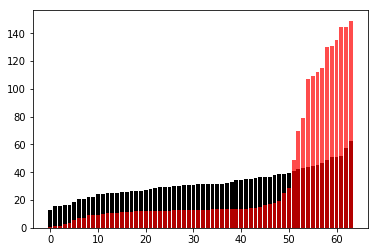

In [102]:
plotDiff(MEConv1Graph[0], MEConv1Graph[1])

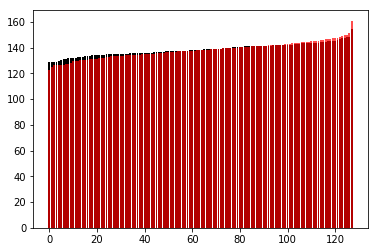

In [103]:
plotDiff(MEConv2Graph[0], MEConv2Graph[1])

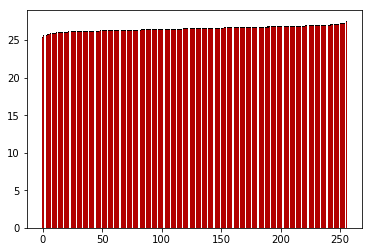

In [64]:
plotDiff(MEConv3Graph[0], MEConv3Graph[1])

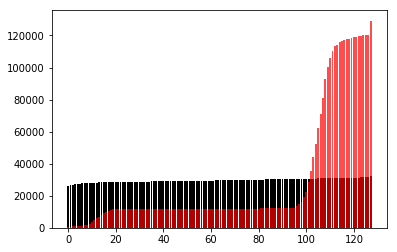

In [105]:
plotDiff(MEFc1Graph[0], MEFc1Graph[1])

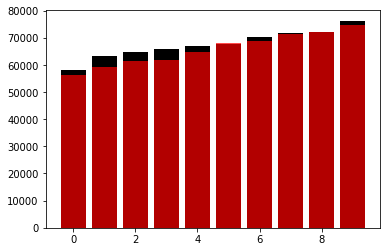

In [45]:
plotDiff(outGraph[0], outGraph[1])